In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # For Mac
plt.rcParams['axes.unicode_minus'] = False  # This is to display minus signs correctly



In [2]:
df_demand = pd.read_csv('./data/demand_train.csv',  encoding="gbk")
df_demand['过账日期'] = pd.to_datetime(df_demand['过账日期'])

df_demand.head(10)

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类
0,2018-01-06,0.33,2004,1000,5000,3002,4014
1,2018-01-08,0.09,2010,1000,5000,3002,4014
2,2018-01-09,0.09,2008,1000,5000,3002,4014
3,2018-01-10,0.10,2010,1000,5000,3002,4014
4,2018-01-11,0.17,2004,1000,5000,3002,4014
5,2018-01-13,0.06,2008,1000,5000,3002,4014
6,2018-01-15,0.45,2004,1000,5000,3002,4014
7,2018-01-18,0.03,2010,1000,5000,3002,4014
8,2018-01-19,0.06,2008,1000,5000,3002,4014
9,2018-01-20,0.84,2004,1000,5000,3002,4014


In [3]:
df_demand['年月'] = df_demand['过账日期'].dt.to_period('M').astype(str)
df_demand['月'] = df_demand['年月'].str[-2:]
df_demand['季度'] = df_demand['过账日期'].dt.quarter
df_demand.head()

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类,年月,月,季度
0,2018-01-06,0.33,2004,1000,5000,3002,4014,2018-01,01,1
1,2018-01-08,0.09,2010,1000,5000,3002,4014,2018-01,01,1
2,2018-01-09,0.09,2008,1000,5000,3002,4014,2018-01,01,1
3,2018-01-10,0.10,2010,1000,5000,3002,4014,2018-01,01,1
4,2018-01-11,0.17,2004,1000,5000,3002,4014,2018-01,01,1


In [4]:
df_demand.drop(['过账日期', '物料品牌', '物料类型', '物料品类'], axis=1, inplace=True)
df_demand.head()

,需求量,工厂编码,物料编码,年月,月,季度
0,0.33,2004,1000,2018-01,01,1
1,0.09,2010,1000,2018-01,01,1
2,0.09,2008,1000,2018-01,01,1
3,0.10,2010,1000,2018-01,01,1
4,0.17,2004,1000,2018-01,01,1


In [5]:
# 经分析 需求量与库存量、物料编码、工厂编码有很大可能存在关联性，考虑到最终预测是通过工厂编码 + 物料编码 进行预测的，故这里将数据进行预处理

df_demand['工厂编码_物料编码'] = df_demand['工厂编码'].astype(str) + '_' + df_demand['物料编码'].astype(str)
df_demand['年'] = df_demand['年月'].str[:4]
df_final = df_demand.groupby(['工厂编码_物料编码', '年月', '年', '月', '季度']).agg({'需求量': 'sum' }).reset_index()
df_final['年'] = df_final['年'].astype(int)
df_final['月'] = df_final['月'].astype(int)
df_final['季度'] = df_final['季度'].astype(int)
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量
0,2000_1001,2018-01,2018,1,1,12.53
1,2000_1001,2018-02,2018,2,1,16.08
2,2000_1001,2018-03,2018,3,1,4.71
3,2000_1001,2018-04,2018,4,2,17.69
4,2000_1001,2018-05,2018,5,2,7.97


In [6]:
def create_features(df, group_col='工厂编码_物料编码', target_col='需求量'):
    """
    创建滑动和滞后特征
    """
    # 按组排序
    df = df.sort_values([group_col, '年', '月'])
    
    # 创建滞后特征
    for lag in [1, 2, 3, 4]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # 创建滑动窗口特征
    for window in [2, 3, 4]:
        df[f's_roll_{window}_mean'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.rolling(window=window).mean())
        df[f's_roll_{window}_max'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.rolling(window=window).max())
        df[f's_roll_{window}_min'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.rolling(window=window).min())
        df[f's_roll_{window}_std'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.rolling(window=window).std())
        df[f's_roll_{window}_median'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.rolling(window=window).median())
    
    # 创建基于滞后特征的滑动窗口特征
    for window in [2, 3, 4]:
        df[f's_l_roll_{window}_mean'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).mean())
        df[f's_l_roll_{window}_max'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).max())
        df[f's_l_roll_{window}_min'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).min())
        df[f's_l_roll_{window}_std'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).std())
        df[f's_l_roll_{window}_median'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).median())
    
    return df

In [7]:

df_final = create_features(df_final)
df_final = df_final.fillna(0)
df_final.head()
    

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
0,2000_1001,2018-01,2018,1,1,12.53,0.00,0.00,0.00,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.0000,0.00,0.00,0.000000,0.000
1,2000_1001,2018-02,2018,2,1,16.08,12.53,0.00,0.00,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.0000,0.00,0.00,0.000000,0.000
2,2000_1001,2018-03,2018,3,1,4.71,16.08,12.53,0.00,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.0000,0.00,0.00,0.000000,0.000
3,2000_1001,2018-04,2018,4,2,17.69,4.71,16.08,12.53,0.00,...,11.106667,16.08,4.71,5.817098,12.53,0.0000,0.00,0.00,0.000000,0.000
4,2000_1001,2018-05,2018,5,2,7.97,17.69,4.71,16.08,12.53,...,12.826667,17.69,4.71,7.075184,16.08,12.7525,17.69,4.71,5.778768,14.305


In [8]:
!pip install scikit-learn 


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final['工厂编码_物料编码'] = le.fit_transform(df_final['工厂编码_物料编码'])
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
0,0,2018-01,2018,1,1,12.53,0.00,0.00,0.00,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.0000,0.00,0.00,0.000000,0.000
1,0,2018-02,2018,2,1,16.08,12.53,0.00,0.00,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.0000,0.00,0.00,0.000000,0.000
2,0,2018-03,2018,3,1,4.71,16.08,12.53,0.00,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.0000,0.00,0.00,0.000000,0.000
3,0,2018-04,2018,4,2,17.69,4.71,16.08,12.53,0.00,...,11.106667,16.08,4.71,5.817098,12.53,0.0000,0.00,0.00,0.000000,0.000
4,0,2018-05,2018,5,2,7.97,17.69,4.71,16.08,12.53,...,12.826667,17.69,4.71,7.075184,16.08,12.7525,17.69,4.71,5.778768,14.305


In [10]:
df_final.describe()

,工厂编码_物料编码,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,s_roll_2_mean,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
count,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,...,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000,14931.000000
mean,470.110240,2019.062220,6.262206,2.427634,155.275829,150.365990,142.809751,135.505889,129.372863,150.638511,...,138.591169,173.990966,104.111423,36.745496,137.671117,133.117824,179.000721,88.874643,41.091967,132.297965
std,279.848246,0.766653,3.242514,1.071164,376.697666,372.349248,361.662425,352.953503,346.807469,367.681921,...,349.995469,423.932565,284.552413,99.371111,356.101756,341.140966,438.880366,250.177763,108.767864,347.233603
min,0.000000,2018.000000,1.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,213.000000,2018.000000,4.000000,2.000000,8.900000,7.000000,4.840000,2.480000,0.600000,7.647500,...,3.565000,5.270000,1.080000,1.155739,3.000000,1.311250,2.240000,0.200000,0.557024,1.060000
50%,502.000000,2019.000000,6.000000,2.000000,38.480000,34.900000,30.440000,25.470000,21.120000,36.140000,...,28.680000,40.080000,16.210000,8.420641,26.600000,25.310000,38.020000,11.520000,8.972121,23.600000
75%,710.000000,2020.000000,9.000000,3.000000,133.610000,128.730000,121.505000,113.130000,104.905000,129.690000,...,115.933333,150.420000,81.425000,31.183106,114.275000,110.200000,154.220000,67.000000,35.262323,108.390000
max,961.000000,2020.000000,12.000000,4.000000,5613.560000,5613.560000,5613.560000,5613.560000,5613.560000,5523.060000,...,5107.226667,5613.560000,4718.720000,2310.003815,5432.560000,4857.800000,5613.560000,4109.520000,2256.583553,4854.060000


In [11]:


# 划分训练集和测试集
df_train = df_final[df_final['年月'] < '2020-09']
df_test = df_final[df_final['年月'] >= '2020-09']
df_test.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
30,0,2020-09,2020,9,3,1.80,6.00,13.20,10.28,21.76,...,9.826667,13.20,6.00,3.621344,10.28,12.81,21.76,6.00,6.659119,11.74
31,0,2020-10,2020,10,4,4.80,1.80,6.00,13.20,10.28,...,7.000000,13.20,1.80,5.765414,6.00,7.82,13.20,1.80,4.984937,8.14
32,0,2020-11,2020,11,4,8.40,4.80,1.80,6.00,13.20,...,4.200000,6.00,1.80,2.163331,4.80,6.45,13.20,1.80,4.834253,5.40
65,1,2020-09,2020,9,3,119.76,60.96,103.72,120.84,146.80,...,95.173333,120.84,60.96,30.841332,103.72,108.08,146.80,60.96,36.061799,112.28
66,1,2020-10,2020,10,4,131.72,119.76,60.96,103.72,120.84,...,94.813333,119.76,60.96,30.395008,103.72,101.32,120.84,60.96,28.022334,111.74


In [12]:
df_test.describe()

,工厂编码_物料编码,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,s_roll_2_mean,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
count,1264.000000,1264.0,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,...,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000
mean,465.265032,2020.0,9.966772,3.648734,207.208018,217.199363,192.267464,171.690949,161.006167,212.153627,...,193.605744,235.989684,152.877148,43.057476,191.950400,185.253340,239.792690,137.599869,45.623198,181.810400
std,280.310353,0.0,0.817758,0.477555,474.952815,483.828760,420.420914,389.815072,371.896928,472.716527,...,425.846800,507.257277,347.261789,90.038084,427.316795,409.836948,511.488973,322.579781,91.676024,405.700302
min,0.000000,2020.0,9.000000,3.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,215.000000,2020.0,9.000000,3.000000,13.120000,16.225000,15.777500,13.915000,13.275000,15.755000,...,16.900000,23.440000,9.595000,4.469467,15.777500,16.305000,24.360000,8.015000,5.483805,15.160000
50%,452.500000,2020.0,10.000000,4.000000,54.280000,64.920000,59.125000,55.245000,50.060000,61.220000,...,61.070000,75.200000,44.050000,14.323376,58.900000,57.730000,76.200000,35.060000,16.438566,58.050000
75%,712.000000,2020.0,11.000000,4.000000,193.580000,212.105000,193.670000,163.790000,156.430000,201.165000,...,191.360000,231.140000,150.060000,41.131203,188.220000,180.760000,234.490000,131.680000,46.555629,177.570000
max,960.000000,2020.0,11.000000,4.000000,5204.560000,5204.560000,4753.360000,5178.320000,5178.320000,4616.080000,...,4565.760000,5204.560000,3765.600000,1062.156637,4753.360000,4522.560000,5204.560000,3765.600000,1132.453601,4573.160000


In [13]:
#  训练模型
features = [col for col in df_final.columns if col not in ['工厂编码_物料编码', '年月', '需求量']]
target = '需求量'


In [14]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title='', clear=True):
    if clear:
        clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

def plot_predict(net, dataset, median):
    xs = [x[0].reshape(1, -1) for x in dataset]
    xs = torch.concat(xs, axis=0)
    ys = [x[1].reshape(1, -1) for x in dataset]
    ys = torch.concat(ys, axis=0)
    with torch.no_grad():
        linear_model.eval()
        predict = linear_model(xs)
        live_plot({'predict': predict[:, 1].detach().numpy(), 'real': ys[:, 1], 'median': [median[1] for i in range(ys.shape[0])]}, clear=True)

In [15]:
import random
def train_net(net, epoch, train_x, train_y, test_x, test_y, optimizer, loss_fn):
    epochs = []
    train_loss = []
    test_loss = []
    for e in range(0, epoch):
        #print("Epoch ", e)
        epochs.append(e)

        # train model
        batch_size = 20000
        net.train()
        overall_mse = torch.tensor(0)
        overall_count = 0
        for batch_start in range(0, len(train_x), batch_size):
            optimizer.zero_grad()
            mse = torch.tensor(0)
            count = 0
            xs = train_x[batch_start:batch_start+batch_size]
            ys = train_y[batch_start:batch_start+batch_size]
            if hasattr(net, 'reset') and callable(getattr(net, 'reset')):
                net.reset()
            pred = net(xs)
            actual = ys
            mse = mse + loss_fn(pred, actual)
            count += pred.shape[0]             

            overall_mse = overall_mse + mse
            overall_count = overall_count + count
            #print("Batch training MSE ", mse / count)
            mse = mse / count  
            mse.backward()
            optimizer.step()
        
        
        print("Overall training MSE ", overall_mse / overall_count)
        train_loss.append((overall_mse / overall_count).detach().numpy())

        #test model
        with torch.no_grad():
            net.eval()
            overall_mse = torch.tensor(0)
            overall_count = 0
            for batch_start in range(0, len(test_x), batch_size):
                mse = torch.tensor(0)
                count = 0
                xs = test_x[batch_start:batch_start+batch_size]
                ys = test_y[batch_start:batch_start+batch_size]
                if hasattr(net, 'reset') and callable(getattr(net, 'reset')):
                    net.reset()
                pred = net(xs)
                actual = ys
                mse = mse + loss_fn(pred, actual)
                count += pred.shape[0]       
                overall_mse = overall_mse + mse
                overall_count = overall_count + count
                mse = mse / count
            
            print("Overall test MSE ", overall_mse / overall_count)
            test_loss.append((overall_mse / overall_count).detach().numpy())

        live_plot({'train': train_loss, 'test': test_loss}, title='loss')
        #plot_predict(net, test_data_set, median)
    return epochs, train_loss, test_loss
        

In [16]:
import torch
to_torch = lambda x: torch.from_numpy(x.values.astype('float32'))
train_x, train_y = to_torch(df_train[features]), to_torch(df_train[target]).reshape(-1, 1)
test_x, test_y = to_torch(df_test[features]), to_torch(df_test[target]).reshape(-1, 1)

feature_num = train_x.shape[1]
output_num = train_y.shape[1]
feature_num, output_num, len(df_train)

(37, 1, 13667)

In [28]:
from torch import nn           


dropout_layer = nn.Dropout(0.5)
middle_size = 1000
linear_model = torch.nn.Sequential(
    nn.Linear(feature_num, middle_size),
    nn.ReLU(),
    dropout_layer,
)

for i in range(0):
    linear_model = linear_model.append(
        torch.nn.Sequential(
            nn.Linear(middle_size, middle_size),
            nn.ReLU(),
            dropout_layer
        )
    )

linear_model = linear_model.append(
    nn.Linear(middle_size, output_num))

optimizer = torch.optim.Adam(linear_model.parameters())
loss_fn = torch.nn.MSELoss(reduction = 'sum')

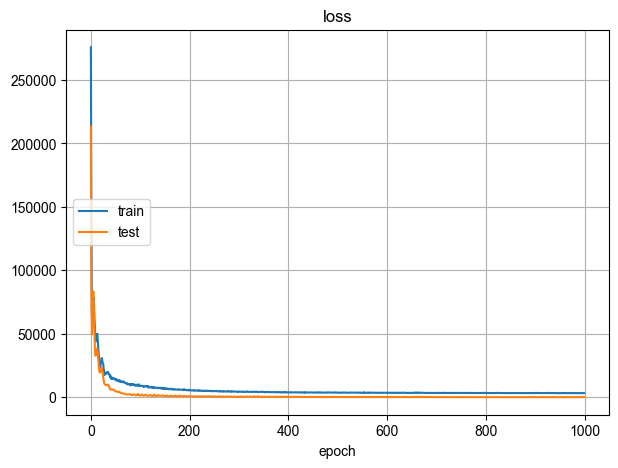

In [29]:
epochs, train_loss, test_loss = train_net(linear_model, 1000, train_x, train_y, test_x, test_y, optimizer, loss_fn)

In [30]:
train_loss[-1], test_loss[-1]

(array(3260.561, dtype=float32), array(172.52226, dtype=float32))

In [31]:
pred_y = linear_model(test_x)

l1loss = torch.nn.L1Loss()
l2loss = torch.nn.MSELoss()

l1loss(test_y, pred_y), l2loss(test_y, pred_y)

(tensor(4.7258, grad_fn=<MeanBackward0>),
 tensor(172.5223, grad_fn=<MseLossBackward0>))

In [32]:
df_predict_lgb = df_test.copy()
df_predict_lgb['预测值'] = pred_y.detach().numpy()  # 添加预测值列

# 2. 计算绝对差异和相对差异
df_predict_lgb['绝对差异'] = df_predict_lgb['预测值'] - df_predict_lgb['需求量']
df_predict_lgb['相对差异(%)'] = (df_predict_lgb['绝对差异'] / df_predict_lgb['需求量']).abs() * 100

# 3. 按绝对差异排序（可选）
df_compare_lgb = df_predict_lgb.sort_values(by='相对差异(%)', key=abs, ascending=False)

# 4. 显示关键列（按需调整显示的列）
columns_to_show = ['工厂编码_物料编码', '年月', '需求量', '预测值', '绝对差异', '相对差异(%)']
df_compare_lgb = df_compare_lgb[columns_to_show]

# 5. 格式化输出（保留两位小数）
pd.options.display.float_format = '{:.2f}'.format
print("预测值与真实值对比表：")
df_compare_lgb.head(10)  # 显示差异最大的前10条样本


预测值与真实值对比表：


,工厂编码_物料编码,年月,需求量,预测值,绝对差异,相对差异(%)
1710,91,2020-09,0.20,25.35,25.15,12575.91
2093,110,2020-11,0.16,17.33,17.17,10732.87
7264,481,2020-09,0.08,5.01,4.93,6162.85
2091,110,2020-09,0.28,16.77,16.49,5890.81
7117,456,2020-11,0.20,11.94,11.74,5869.87
10114,648,2020-10,0.04,2.33,2.29,5727.98
2638,154,2020-09,0.40,21.12,20.72,5179.51
2092,110,2020-10,0.48,16.77,16.29,3393.40
3818,222,2020-09,0.80,26.67,25.87,3233.85
2057,109,2020-10,0.54,17.64,17.10,3167.32


In [34]:
df_compare_lgb.describe()

,工厂编码_物料编码,需求量,预测值,绝对差异,相对差异(%)
count,1264.00,1264.00,1264.00,1264.00,1264.00
mean,465.27,207.21,210.93,3.73,95.27
std,280.31,474.95,482.79,12.60,650.17
min,0.00,0.04,0.30,-43.18,0.00
25%,215.00,13.12,14.50,-0.49,1.28
50%,452.50,54.28,54.24,1.03,2.96
75%,712.00,193.58,198.70,4.33,6.51
max,960.00,5204.56,5281.57,203.52,12575.91


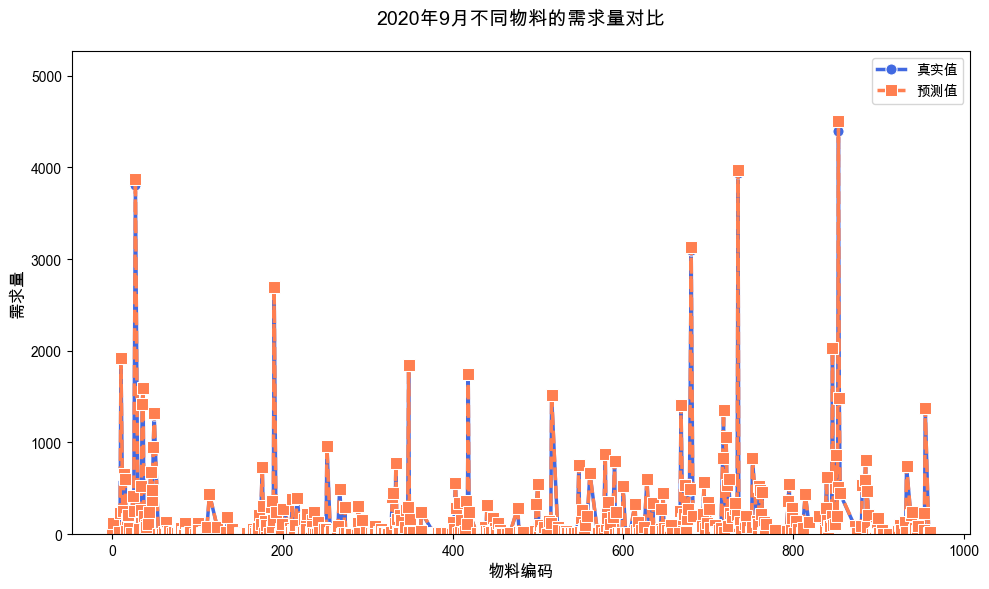

In [33]:
df_test_lgb_9 = df_predict_lgb[df_test['年月'] == '2020-09']
plt.figure(figsize=(10, 6))

# 绘制折线图（带标记点）
lineplot = sns.lineplot(
    data=df_test_lgb_9,
    x='工厂编码_物料编码',
    y='需求量',
    marker='o',
    markersize=8,
    linewidth=2.5,
    color='royalblue',
    label='真实值'
)
sns.lineplot(
    data=df_test_lgb_9,
    x='工厂编码_物料编码',
    y='预测值',
    marker='s',
    markersize=8,
    linewidth=2.5,
    color='coral',
    linestyle='--',
    label='预测值'
)

plt.title('2020年9月不同物料的需求量对比', fontsize=14, pad=20)
plt.xlabel('物料编码', fontsize=12)
plt.ylabel('需求量', fontsize=12)

# 调整Y轴范围（考虑数值差异大的情况）
plt.ylim(0, df_test_lgb_9['需求量'].max() * 1.2)

# 显示图表
plt.tight_layout()
plt.show()